# Final Project: Analyzing Connectomes in a Cat

***

**Name**: Teddy Heckelman and Keyin Huang


***


In [86]:
############## IMPORTS #################
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline

In [87]:
fname = 'mixed.species_brain_1.graphml'
print(f'reading the network file : {fname}\n')
G = nx.read_graphml('./' + fname) 

reading the network file : mixed.species_brain_1.graphml



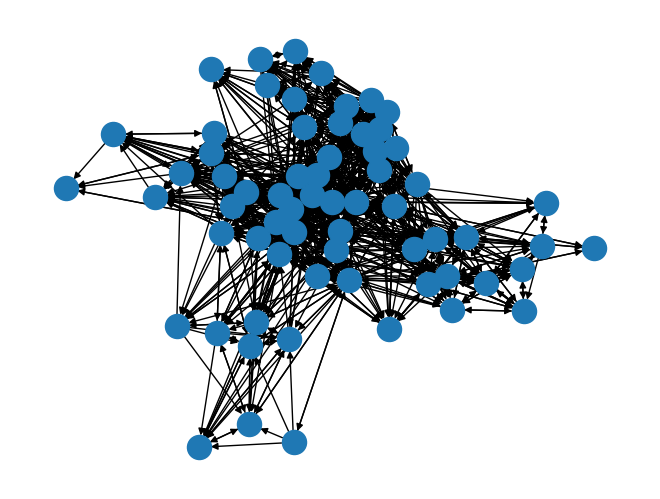

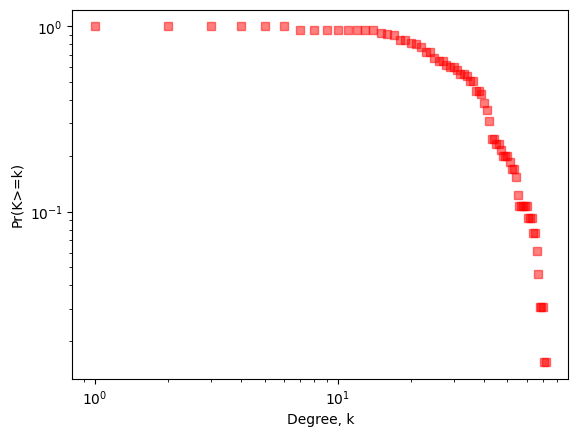

number of nodes, n  = 65
number of edges, m  = 1139
mean degree,    <k> = 35.05
clustering coefficient, C     =  0.47
mean geodesic distance, <ell> =  1.86


In [88]:
s = nx.draw(G, pos = nx.spring_layout(G))
plt.show(s) #spring
n = G.number_of_nodes()
m = G.number_of_edges()
kmean = 2*m/n
C = nx.transitivity(G)
ellmean = nx.average_shortest_path_length(G)
l = sorted(G.degree, key=lambda x: x[1], reverse=True)
list_of_degrees = []
for i in range(len(l)):
    list_of_degrees.append(l[i][1])
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

plot_CCDF(list_of_degrees)



print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)



### Part 1: Rich Club Analysis:

* Compute the degree distribution of the network to determine the rich club regime.
* Calculate the rich club coefficient for different levels of connectivity (k) and compare it with null models to establish rich club organization.
* Identify the top-ranking nodes to form the rich club based on predetermined criteria (top 15 highest-degree nodes).


In [96]:
def compute_MGD(G):
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)

    # YOUR CODE HERE
    path = 0
    z = 0

    all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G)) #total shortest paths for all pairs
    
    for nodes in all_shortest_paths: #for each node
        all_nodes = list(all_shortest_paths[nodes].values()) #all shortest path to all nodes
        for distance in all_nodes: #the distance of paths to each nodes
            if distance != 0: #is path exists
                path += distance #add length
                z +=1 #increment number of paths

    if z == 0: 
         mgd = 0
    else:
        mgd = (1/z) * path #computing average geodesic distance

    return mgd

def compute_MGD_Gnp(n,p,rep):
    # input : a number of nodes 'n', edge density parameter 'p', and number of repetitions 'rep'
    # output: the mean geodesic path length of G(n,p), averaged over 'rep' instances
    
    # YOUR CODE HERE
    ns = np.logspace(4,10,num=7,base=2)  # number of nodes: 2^{4:10}
    ns = ns.astype(int)                  # convert to ints
    ellm = []   
    
    for i in range(rep): 
            G = nx.fast_gnp_random_graph(n, p)
            ellm.append(compute_MGD(G))
    
    return sum(ellm) / rep

def plot_nullAndEmpirical(nulls,emp,qlabel,nlabel,elabel,xlim,ylim):
    # input: nulls, a list of values representing a null (reference) distribution
    #        emp, the empirical value to be compared to the null
    #        qlabel [string], the name of the empirical quantity, e.g., '<ell>' or 'C'
    #        nlabel [string], the name of the null data series
    #        elabel [string], the name of the empirical data source
    #        xlim [scalar], the upper limit of the x-axis
    #        ylim [scalar], the upper limit of the y-axis

    counts, bins = np.histogram(nulls,bins=50,range=(0,xlim), density=True)
    nreps = len(nulls)

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(bins[:-1], counts/100, 'b-', alpha=0.5, label=nlabel)
    plt.plot([emp, emp], [0, ylim], 'r-', alpha=0.5, label=elabel)
    plt.xlabel(qlabel)
    plt.ylabel('Pr('+qlabel+')')
    plt.xlim(0, xlim)
    plt.legend(loc='upper right')
    plt.show()
    
    return

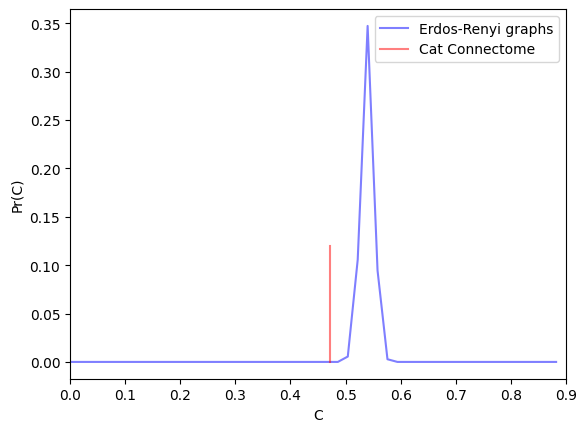

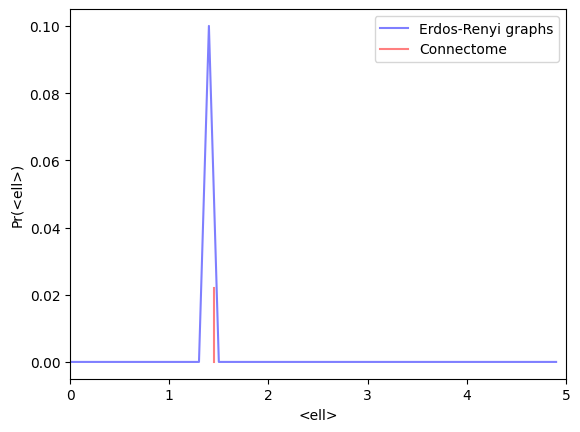

In [97]:
###

Cs   = []  # store the null values of C here
ells = []  # store the null values of ellmean here
##### do not modify above here #####


# YOUR CODE HERE
for i in range(200):
    p = kmean/(n-1)
    ER = nx.fast_gnp_random_graph(n, p)
    new_c = nx.transitivity(ER)
    ellmean = compute_MGD(ER)
    Cs.append(new_c)
    ells.append(ellmean)

##### do not modify below here #####
plot_nullAndEmpirical(Cs,C,'C','Erdos-Renyi graphs','Cat Connectome',0.9,0.12)
plot_nullAndEmpirical(ells,ellmean,'<ell>','Erdos-Renyi graphs','Connectome',5,0.022)

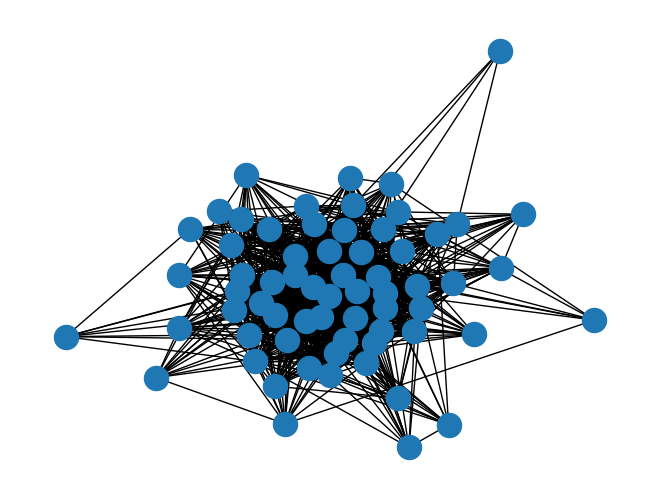

In [98]:
degree_sequence = list(dict(G.degree()).values())
CL = nx.expected_degree_graph(degree_sequence, selfloops=False)

nx.draw_spring(CL)
plt.show()

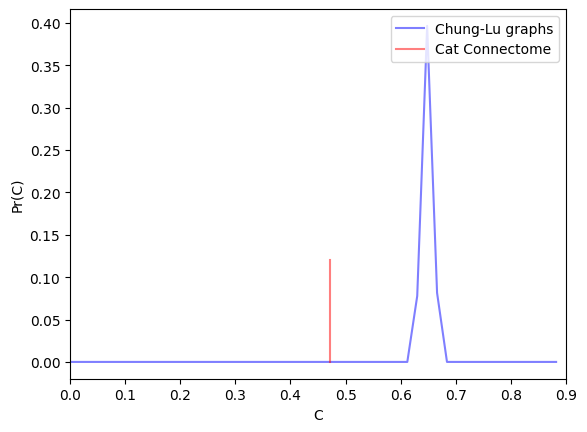

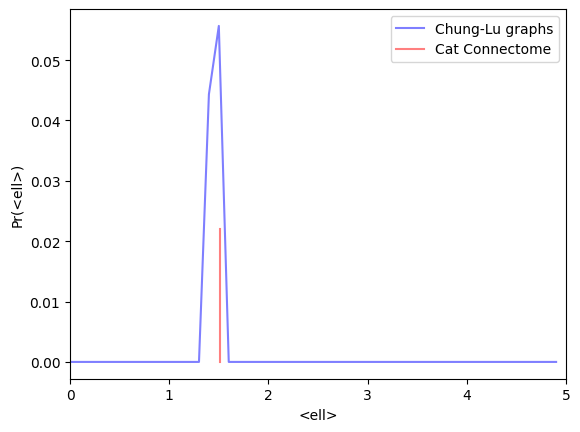

In [99]:
Cs   = []  # store the null values of C here
ells = []  # store the null values of ellmean here
##### do not modify above here #####


# YOUR CODE HERE

for i in range(300):
    CL = nx.expected_degree_graph(degree_sequence, selfloops=False)
    new_c = nx.transitivity(CL)
    ellmean = compute_MGD(CL)
    Cs.append(new_c)
    ells.append(ellmean)

##### do not modify below here #####
plot_nullAndEmpirical(Cs,C,'C','Chung-Lu graphs','Cat Connectome',0.9,0.12)
plot_nullAndEmpirical(ells,ellmean,'<ell>','Chung-Lu graphs','Cat Connectome',5,0.022)

### Null Graph for top 15 highest degree nodes

In [131]:
# Get the first 15 tuples and their first values
first_15_tuples = l[:15]
top_15_nodes = [tup[0] for tup in first_15_tuples]
top_15_degrees = [tup[1] for tup in first_15_tuples]

# Get the last 15 tuples and their first values
last_15_tuples = l[-15:]
bottom_15_nodes = [tup[0] for tup in last_15_tuples]
bottom_15_degrees = [tup[1] for tup in last_15_tuples]


# Extract the subgraph containing only the nodes of interest
top_15_subgraph = G.subgraph(top_15_nodes)
bottom_15_subgraph = G.subgraph(bottom_15_nodes)


# Calculate the transitivity of the subgraph
top_15_transitivity = nx.transitivity(top_15_subgraph)
bottom_15_transitivity = nx.transitivity(bottom_15_subgraph)

#ellemean
ellmean_top = nx.average_shortest_path_length(top_15_subgraph)


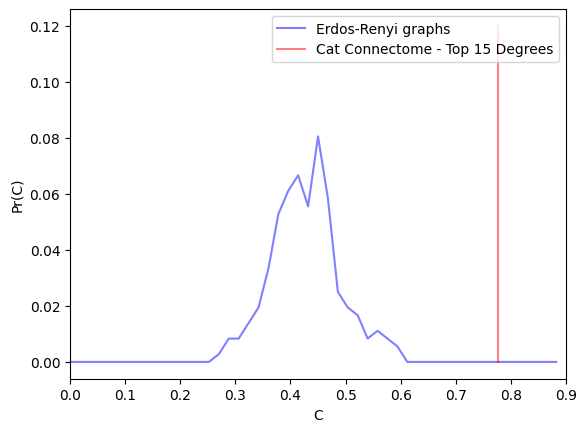

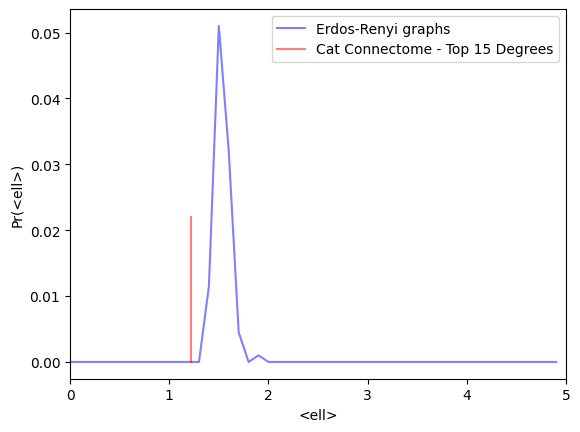

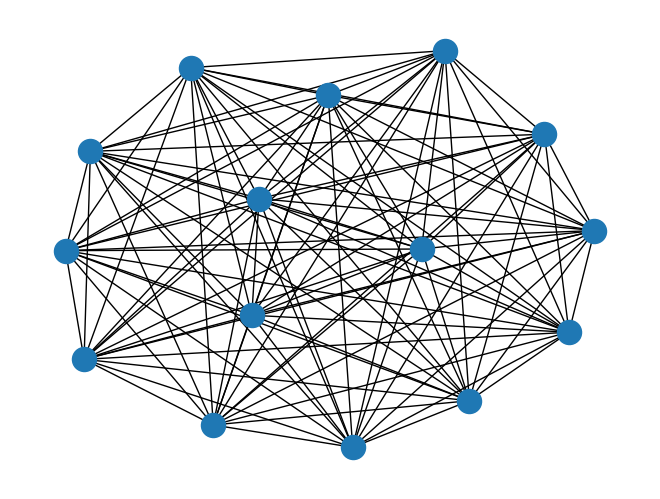

In [132]:
### top 15 nodes vs bottom 15

Cs   = []  # store the null values of C here
ells = []  # store the null values of ellmean here
##### do not modify above here #####

num_nodes = top_15_subgraph.number_of_nodes()
num_edges = top_15_subgraph.number_of_edges()
top_15_kmean = 2*num_edges/num_nodes
#bottom_15_kmean = (2*(bottom_15_subgraph.number_of_edges()))/(bottom_15_subgraph.number_of_nodes())


# YOUR CODE HERE
for i in range(200):
    p = top_15_kmean/num_nodes-1
    SUBGRAPH = nx.fast_gnp_random_graph(num_nodes, p)
    new_c = nx.transitivity(SUBGRAPH)
    ellmean = compute_MGD(SUBGRAPH)
    Cs.append(new_c)
    ells.append(ellmean)

##### do not modify below here #####
plot_nullAndEmpirical(Cs,top_15_transitivity,'C','Erdos-Renyi graphs','Cat Connectome - Top 15 Degrees',0.9,0.12)
plot_nullAndEmpirical(ells,ellmean_top,'<ell>','Erdos-Renyi graphs','Cat Connectome - Top 15 Degrees',5,0.022)


CL_TOP = nx.expected_degree_graph(top_15_degrees, selfloops=False)

nx.draw_spring(CL_TOP)
plt.show()



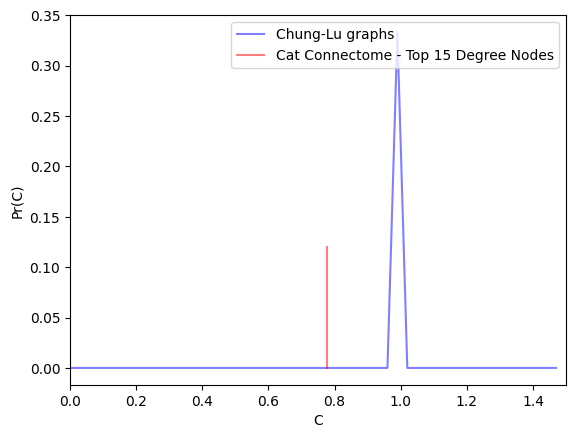

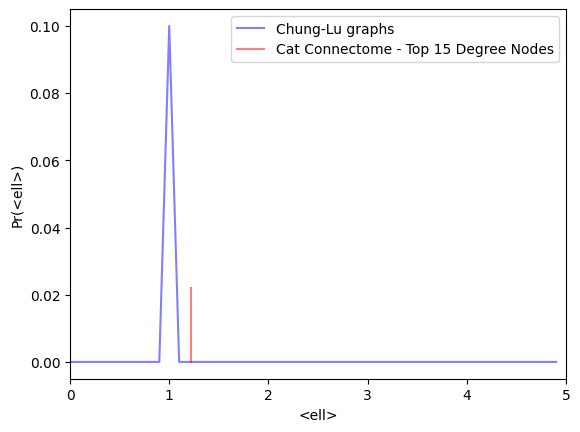

In [135]:
Cs   = []  # store the null values of C here
ells = []  # store the null values of ellmean here
##### do not modify above here #####


# YOUR CODE HERE

for i in range(300):
    CL_T = nx.expected_degree_graph(top_15_degrees, selfloops=False)
    new_c = nx.transitivity(CL_T)
    ellmean = compute_MGD(CL_T)
    Cs.append(new_c)
    ells.append(ellmean)
    
##### do not modify below here #####
plot_nullAndEmpirical(Cs,top_15_transitivity,'C','Chung-Lu graphs','Cat Connectome - Top 15 Degree Nodes',1.5,0.12)
plot_nullAndEmpirical(ells,ellmean_top,'<ell>','Chung-Lu graphs','Cat Connectome - Top 15 Degree Nodes',5,0.022)

Discuss evidence of rich club hubs: <br><br>
Part one focuses on proving the precense of rich club hubs which are relatively small but crucial set of highly connected regions that play a central role in the overall architecture of brain networks. In order to prove this, there needs to be a range of nodes that are highly connected. Since we know high degree nodes are dense and highly connected, we made a subgraph consisting of the top 15 highest-degree nodes and compared it to the Erdos-Renyi and Chung-Lu graph. As expected, the clustering coefficent is much higher than the normalized coefficient in the Erdos-Renyi graph, proving a highly connected and dense hub, in other words, the rich club hub. 


### Part 2: Functional Module Identification:
* Use the provided functional categorization of cortical regions to classify nodes into distinct functional modules (visual, auditory, somatomotor, 
* frontolimbic).
* Apply community detection algorithms to verify the initial module classification and potentially refine it based on network connectivity patterns.


Discuss how hubs are organzied and the architecure:

### Part 3: Node Classification:
* Compute node metrics such as within-module degree z-score and between-module participation coefficient to classify nodes into different roles (intermodal hubs, intramodule hubs).
* Rank nodes based on these metrics and identify nodes that display high levels of intramodular connectivity.


Discuss our findings of the inter and intramodule nodes and what this says about the architecture of the network and how information is passed.

### Part 4: Centrality Analysis: (not sure how to do this)
* Calculate betweenness centrality and PageRank centrality for each node to assess their importance in global network communication.
* Compare centrality metrics across nodes to identify central nodes in the network.


Discuss our findings and what is says about the importance of global network communication

### Part 5: Path Motif Analysis:
* Compute all shortest communication paths in the network and label them with categories of connections (rich club, feeder, local).
* Determine the prevalence of each unique sequence of connections (path motifs) to understand the organization of communication pathways.
* Compare path motif counts with those in randomized networks to assess significance.


Discuss the correlation between type of connection (rich club, feeder, local) and its communcation. what does the correlation tell us about the architerture and how communication is passed.

### Part 6: Statistical Analysis: (for presentation)
* Perform permutation testing to assess statistical significance of group differences on node and connection metrics.
* Evaluate the structural homogeneity and module diversity of connections to understand their role in network organization.


### Part 7: Visualization and Interpretation: (for presentation)
* Visualize the network structure, rich club nodes, functional modules, and communication pathways to gain insights into the organization of the cat brain network.
* Interpret the findings in the context of existing literature and theoretical frameworks related to brain network organization.
